In [ ]:
# Opciones de decodificación para otros parámetros
layer_type_options = {
    0: 'Conv2D',
    1: 'BatchNorm',
    2: 'MaxPooling',
    3: 'Dropout',
    4: 'Dense',
    5: 'Flatten',
    6: 'DepthwiseConv2D',
    7: 'DontCare',
    8: 'Repetition'
}
stride_options = {0: 1, 1: 2}
dropout_options = {0: 0.2, 1: 0.3, 2: 0.4, 3: 0.5}
activation_options = {0: 'relu', 1: 'leaky_relu', 2: 'sigmoid', 3: 'tanh'}

# Función para codificar los parámetros de la capa
def encode_layer_params(layer_type_idx, param1=0, param2=0, param3=0):
    """
    Codifica una capa en una lista en función del tipo de capa y sus parámetros.

    layer_type_idx : int : índice del tipo de capa según layer_type_options.
    param1         : int/float : filtros, neuronas, capas de repetición, etc.
    param2         : int : stride, número de repeticiones, etc.
    param3         : int : índice de activación o tasa de dropout.
    """
    return [layer_type_idx, param1, param2, param3]

# Función para decodificar los parámetros de la capa
def decode_layer_params(encoded_params):
    """
    Decodifica una capa desde su representación codificada en parámetros interpretables.

    encoded_params : list : [tipo de capa, param1, param2, param3].
    """
    layer_type_idx = encoded_params[0]
    layer_type = layer_type_options.get(layer_type_idx, 'DontCare')

    # Decodificar en función del tipo de capa
    if layer_type in ['Conv2D', 'DepthwiseConv2D']:
        filters = max(4, min(encoded_params[1], 32))  # Limitar filtros entre 4 y 32
        strides = stride_options.get(encoded_params[2], 1)
        activation = activation_options.get(encoded_params[3], 'relu')
        return {
            'type': layer_type,
            'filters': filters,
            'strides': strides,
            'activation': activation
        }
    elif layer_type == 'BatchNorm':
        return {'type': 'BatchNorm'}
    elif layer_type == 'MaxPooling':
        strides = stride_options.get(encoded_params[1], 1)
        return {'type': 'MaxPooling', 'strides': strides}
    elif layer_type == 'Dropout':
        rate = dropout_options.get(encoded_params[1], 0.2)
        return {'type': 'Dropout', 'rate': rate}
    elif layer_type == 'Dense':
        units = max(1, min(encoded_params[1], 512))  # Limitar unidades entre 1 y 512
        activation = activation_options.get(encoded_params[2], 'relu')
        return {'type': 'Dense', 'units': units, 'activation': activation}
    elif layer_type == 'Flatten':
        return {'type': 'Flatten'}
    elif layer_type == 'Repetition':
        return {
            'type': 'Repetition',
            'repetition_layers': int(encoded_params[1]),
            'repetition_count': int(encoded_params[2])
        }
    elif layer_type == 'DontCare':
        return {'type': "DontCare"}

    return None

# Ejemplos de codificación y decodificación
encoded_conv2d = encode_layer_params(0, 16, 0, 0)  # Conv2D con 16 filtros, stride 1 y activación ReLU
decoded_conv2d = decode_layer_params(encoded_conv2d)
print(f"\nCodificación real de Conv2D: {encoded_conv2d}")
print(f"Decodificación Conv2D: {decoded_conv2d}")

encoded_dropout = encode_layer_params(3, 1)  # Dropout con tasa de 0.3
decoded_dropout = decode_layer_params(encoded_dropout)
print(f"\nCodificación real de Dropout: {encoded_dropout}")
print(f"Decodificación Dropout: {decoded_dropout}")

encoded_dense = encode_layer_params(4, 128, 0)  # Dense con 128 neuronas y activación ReLU
decoded_dense = decode_layer_params(encoded_dense)
print(f"\nCodificación real de Dense: {encoded_dense}")
print(f"Decodificación Dense: {decoded_dense}")

encoded_repetition = encode_layer_params(8, 3, 5)  # Repetition para repetir las últimas 3 capas 5 veces
decoded_repetition = decode_layer_params(encoded_repetition)
print(f"\nCodificación real de Repetition: {encoded_repetition}")
print(f"Decodificación Repetition: {decoded_repetition}")



Codificación real de Conv2D: [0, 16, 0, 0]
Decodificación Conv2D: {'type': 'Conv2D', 'filters': 16, 'strides': 1, 'activation': 'relu'}

Codificación real de Dropout: [3, 1, 0, 0]
Decodificación Dropout: {'type': 'Dropout', 'rate': 0.3}

Codificación real de Dense: [4, 128, 0, 0]
Decodificación Dense: {'type': 'Dense', 'units': 128, 'activation': 'relu'}

Codificación real de Repetition: [8, 3, 5, 0]
Decodificación Repetition: {'type': 'Repetition', 'repetition_layers': 3, 'repetition_count': 5}


In [ ]:
def int_to_real_dom(num, domain):
  min_i, max_i = domain
  r = (num - min_i) / (max_i - min_i)
  return r

def real_to_int_dom(num, domain):
  min_i, max_i = domain
  value = min_i + num * (max_i - min_i)
  if isinstance(min_i, int) and isinstance(max_i, int):
      value = int(round(value))
  return value

def convert_individual(ind, to_real=True):
    real_rep = []
    N = max(layer_type_options.keys())
    for i in range(0, len(ind), 4):
        layer_type_idx = ind[i]
        domain_layer_type = [0, N]
        if to_real:
            real_rep.append(int_to_real_dom(layer_type_idx, domain_layer_type))
            layer_type = layer_type_options.get(layer_type_idx, 'DontCare')
        else:
            real_rep.append(real_to_int_dom(layer_type_idx, domain_layer_type))
            layer_type = layer_type_options.get(real_rep[i], 'DontCare')

        # Decode based on layer type
        if layer_type in ['Conv2D', 'DepthwiseConv2D']:
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [4, 32]))
                real_rep.append(int_to_real_dom(ind[i + 2], [0, 1]))
                real_rep.append(int_to_real_dom(ind[i + 3], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [4, 32]))
                real_rep.append(real_to_int_dom(ind[i + 2], [0, 1]))
                real_rep.append(real_to_int_dom(ind[i + 3], [0, 3]))
        elif layer_type == 'BatchNorm':
            real_rep.extend([0, 0, 0])
        elif layer_type == 'MaxPooling':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [0, 1]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [0, 1]))
            real_rep.extend([0, 0])
        elif layer_type == 'Dropout':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [0, 3]))
            real_rep.extend([0, 0])
        elif layer_type == 'Dense':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [1, 512]))
                real_rep.append(int_to_real_dom(ind[i + 2], [0, 3]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [1, 512]))
                real_rep.append(real_to_int_dom(ind[i + 2], [0, 3]))
            real_rep.append(0)
        elif layer_type == 'Flatten':
            real_rep.extend([0, 0, 0])
        elif layer_type == 'Repetition':
            if to_real:
                real_rep.append(int_to_real_dom(ind[i + 1], [1, 4]))
                real_rep.append(int_to_real_dom(ind[i + 2], [1, 32]))
            else:
                real_rep.append(real_to_int_dom(ind[i + 1], [1, 4]))
                real_rep.append(real_to_int_dom(ind[i + 2], [1, 32]))
            real_rep.append(0)
        elif layer_type == 'DontCare':
            real_rep.extend([0, 0, 0])
    return real_rep

In [ ]:
x = [1, 0, 0, 0, 6, 5, 0, 2, 8, 1, 1, 0, 4, 17, 3, 0, 4, 22, 0, 0, 7, 0, 0, 0, 0, 11, 1, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4, 63, 3, 0, 1, 0, 0, 0, 5, 0, 0, 0]
print(x)
y = convert_individual(x)
print(y)
z = convert_individual(y, to_real=False)
print(z)

[1, 0, 0, 0, 6, 5, 0, 2, 8, 1, 1, 0, 4, 17, 3, 0, 4, 22, 0, 0, 7, 0, 0, 0, 0, 11, 1, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4, 63, 3, 0, 1, 0, 0, 0, 5, 0, 0, 0]
[0.125, 0, 0, 0, 0.75, 0.03571428571428571, 0.0, 0.6666666666666666, 1.0, 0.0, 0.0, 0, 0.5, 0.03131115459882583, 1.0, 0, 0.5, 0.0410958904109589, 0.0, 0, 0.875, 0, 0, 0, 0.0, 0.25, 1.0, 1.0, 0.375, 0.0, 0, 0, 0.375, 0.3333333333333333, 0, 0, 0.5, 0.12133072407045009, 1.0, 0, 0.125, 0, 0, 0, 0.625, 0, 0, 0]
[1, 0, 0, 0, 6, 5, 0, 2, 8, 1, 1, 0, 4, 17, 3, 0, 4, 22, 0, 0, 7, 0, 0, 0, 0, 11, 1, 3, 3, 0, 0, 0, 3, 1, 0, 0, 4, 63, 3, 0, 1, 0, 0, 0, 5, 0, 0, 0]


In [ ]:
import tensorflow as tf

# Clase para capas neutrales 'DontCare'
class DontCareLayer(tf.keras.layers.Layer):
    def __init__(self):
        super(DontCareLayer, self).__init__()

    def call(self, inputs):
        return inputs

In [ ]:
def encode_model_architecture(model_dict, max_alleles=48):
    """
    Codifica la arquitectura del modelo en una lista de valores con un máximo de `max_alleles`.
    Cada capa se codifica en función de sus parámetros.
    """
    encoded_layers = []
    total_alleles = 0

    for layer in model_dict['layers']:
        if layer['type'] == 'Repetition':  # Codificar capa de repetición
            encoded_layer = encode_layer_params(
                layer_type_idx=8,  # índice para 'Repetition'
                param1=layer.get('repetition_layers', 0),
                param2=layer.get('repetition_count', 1)
            )
        else:
            layer_type_idx = next(
                key for key, value in layer_type_options.items() if value == layer['type']
            )

            # Codificar parámetros específicos de cada tipo de capa
            if layer['type'] in ['Conv2D', 'DepthwiseConv2D']:
                # Limitar filtros dentro del rango [4, 32]
                param1 = max(4, min(layer.get('filters', 8), 32))
                param2 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                param3 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, param3]

            elif layer['type'] == 'Dense':
                # Limitar neuronas dentro del rango [1, 512]
                param1 = max(1, min(layer.get('units', 1), 512))
                param2 = next((key for key, value in activation_options.items() if value == layer.get('activation', 'relu')), 0)
                encoded_layer = [layer_type_idx, param1, param2, 0]

            elif layer['type'] == 'MaxPooling':
                param1 = next((key for key, value in stride_options.items() if value == layer.get('strides', 1.0)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'Dropout':
                param1 = next((key for key, value in dropout_options.items() if value == layer.get('rate', 0.2)), 0)
                encoded_layer = [layer_type_idx, param1, 0, 0]

            elif layer['type'] == 'BatchNorm':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'Flatten':
                encoded_layer = [layer_type_idx, 0, 0, 0]

            elif layer['type'] == 'DontCare':
                encoded_layer = [layer_type_idx, 0, 0, 0]

        # Añadir la codificación de la capa a la lista de alelos
        encoded_layers.extend(encoded_layer)
        total_alleles += len(encoded_layer)

    # Rellenar con 'DontCare' si el total de alelos es menor que `max_alleles`
    while total_alleles < max_alleles:
        dont_care_encoding = encode_layer_params(7)  # índice de 'DontCare'
        encoded_layers.extend(dont_care_encoding)
        total_alleles += len(dont_care_encoding)

    # Recortar si excede `max_alleles`
    final_encoding = encoded_layers[:max_alleles]
    #print(f"Final Encoded Model: {final_encoding}")

    return final_encoding


In [ ]:
import random

def fixArch(encoded_model, verbose=False):
    """
    Corrige la arquitectura codificada del modelo, asegurando que:
    - Se evite la presencia de capas incompatibles después de una capa Flatten.
    - En caso de una capa de Repetition, se ajuste el alcance de repetición si no hay suficientes capas anteriores.

    Parameters:
        encoded_model (list): Lista codificada de la arquitectura del modelo.
        verbose (bool): Si es True, muestra las correcciones realizadas.

    Returns:
        list: Lista con la arquitectura corregida, truncada a un máximo de 48 alelos.
    """

    fixed_layers = []  # Lista que almacenará la arquitectura corregida
    input_is_flattened = False  # Indicador para saber si ya hay una capa Flatten en el modelo
    index = 0  # Índice para recorrer el modelo codificado

    # Procesar cada capa en el modelo sin forzar la primera capa a ser específica
    while index < len(encoded_model) and len(fixed_layers) < 48:
        layer_type = int(encoded_model[index])  # Obtener el tipo de capa actual

        # Procesar la capa de Repetition
        if layer_type == 8:
            repetition_layers = int(encoded_model[index + 1])  # Número de capas a repetir
            repetition_count = min(max(int(encoded_model[index + 2]), 0), 32)  # Cantidad de repeticiones

            # Verificar si hay suficientes capas para la repetición solicitada
            actual_layers_to_repeat = min(repetition_layers, len(fixed_layers) // 4)

            if actual_layers_to_repeat != repetition_layers:
                if verbose:
                    print(f"Ajustando alcance de repetición de {repetition_layers} a {actual_layers_to_repeat} debido a falta de capas.")
                repetition_layers = actual_layers_to_repeat

            # Añadir la capa de repetición sin modificar su estructura
            fixed_layers.extend([layer_type, repetition_layers, repetition_count, 0])
            index += 4
            continue

        # Procesar cada tipo de capa normal con sus restricciones
        if layer_type == 0:  # Conv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 6:  # DepthwiseConv2D
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                # Limitar el número de filtros entre 4 y 32
                filters = min(max(int(encoded_model[index + 1]), 4), 32)
                stride_idx = min(max(int(encoded_model[index + 2]), 0), 1)
                activation_idx = min(max(int(encoded_model[index + 3]), 0), 3)
                fixed_layers.extend([layer_type, filters, stride_idx, activation_idx])

        elif layer_type == 2:  # MaxPooling
            if input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                stride_idx = min(max(int(encoded_model[index + 1]), 0), 1)
                fixed_layers.extend([layer_type, stride_idx, 0, 0])

        elif layer_type == 3:  # Dropout
            rate_idx = min(max(int(encoded_model[index + 1]), 0), 3)
            fixed_layers.extend([layer_type, rate_idx, 0, 0])

        elif layer_type == 4:  # Dense
            # Limitar el número de neuronas entre 1 y 512
            neurons = min(max(int(encoded_model[index + 1]), 1), 512)
            activation_idx = min(max(int(encoded_model[index + 2]), 0), 3)
            fixed_layers.extend([layer_type, neurons, activation_idx, 0])

        elif layer_type == 1:  # BatchNorm
            fixed_layers.extend([layer_type, 0, 0, 0])

        elif layer_type == 5:  # Flatten
            if len(fixed_layers) < 16:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            elif input_is_flattened:
                fixed_layers.extend([7, 0, 0, 0])  # DontCare
            else:
                fixed_layers.extend([layer_type, 0, 0, 0])
                input_is_flattened = True  # Marcar que ya hay un Flatten

        elif layer_type == 7:  # DontCare
            fixed_layers.extend([layer_type, 0, 0, 0])

        else: # DontCare
          fixed_layers.extend([7, 0, 0, 0])

        index += 4  # Avanzar al siguiente grupo de parámetros

    return fixed_layers[:48]  # Limitar a 48 alelos


In [ ]:
def decode_model_architecture(encoded_model):
    """
    Decodifica la arquitectura del modelo a partir de la lista codificada de valores (índices),
    aplicando las reglas de repetición y asegurando la inclusión de una capa convolucional inicial.
    """
    model_dict = {'layers': [{'type': 'Conv2D', 'filters': 32, 'strides': 1, 'activation': 'relu'}]}  # Inserta Conv2D inicial
    index = 0

    while index < len(encoded_model):
        layer_type = int(encoded_model[index])
        param1 = encoded_model[index + 1]
        param2 = encoded_model[index + 2]
        param3 = encoded_model[index + 3]

        if layer_type == 8:  # Capa de Repetition
            repetition_layers = int(param1)
            repetition_count = int(param2)
            # Selecciona solo el grupo válido de capas para la repetición
            layers_to_repeat = select_group_for_repetition(model_dict['layers'], repetition_layers)

            if len(layers_to_repeat) > 0:
                for _ in range(repetition_count):
                    model_dict['layers'].extend(layers_to_repeat)

        else:
            decoded_layer = {}

            if layer_type == 0:  # Conv2D
                decoded_layer = {
                    'type': 'Conv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 6:  # DepthwiseConv2D
                decoded_layer = {
                    'type': 'DepthwiseConv2D',
                    'filters': max(4, min(param1, 32)),  # Limita `filters` entre 4 y 32
                    'strides': stride_options.get(param2, 1),
                    'activation': activation_options.get(param3, 'relu')
                }
            elif layer_type == 2:  # MaxPooling
                decoded_layer = {
                    'type': 'MaxPooling',
                    'strides': stride_options.get(param1, 1)
                }
            elif layer_type == 3:  # Dropout
                decoded_layer = {
                    'type': 'Dropout',
                    'rate': dropout_options.get(param1, 0.2)
                }
            elif layer_type == 4:  # Dense
                decoded_layer = {
                    'type': 'Dense',
                    'units': max(1, min(param1, 512)),  # Limita `units` entre 1 y 512
                    'activation': activation_options.get(param2, 'relu')
                }
            elif layer_type == 1:  # BatchNorm
                decoded_layer = {'type': 'BatchNorm'}
            elif layer_type == 5:  # Flatten
                decoded_layer = {'type': 'Flatten'}
            elif layer_type == 7:  # DontCare
                decoded_layer = {'type': 'DontCare'}

            model_dict['layers'].append(decoded_layer)

        index += 4

    # Asegura que haya una capa Flatten antes de la capa Dense final, si no ya existe una Flatten
    if model_dict['layers'][-1]['type'] != 'Flatten':
        model_dict['layers'].append({'type': 'Flatten'})

    # Añade la capa Dense final obligatoria
    model_dict['layers'].append({'type': 'Dense', 'units': 1, 'activation': 'sigmoid'})

    return model_dict

def select_group_for_repetition(layers, repetition_layers):
    """
    Selecciona el primer grupo válido para repetición en función de las reglas de compatibilidad.

    Parameters:
        layers (list): Lista de capas ya procesadas, donde cada capa es un diccionario.
        repetition_layers (int): Número de capas hacia atrás para considerar en la repetición.

    Returns:
        list: Lista de capas compatibles para repetición.
    """
    valid_layers = []
    group_type = None

    # Retrocede desde el final de `layers` para encontrar el grupo válido
    for layer in reversed(layers[-repetition_layers:]):
        if group_type is None:
            # Determina el tipo de grupo
            if layer['type'] in ['Flatten', 'Dense']:
                group_type = 'dense'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling']:
                group_type = 'convolutional'
                valid_layers.insert(0, layer)
            elif layer['type'] in ['BatchNorm', 'DontCare']:  # BatchNorm y DontCare son compatibles con ambos grupos
                valid_layers.insert(0, layer)
        else:
            # Agrega solo capas compatibles con el grupo seleccionado
            if group_type == 'dense' and layer['type'] in ['Flatten', 'Dense', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)
            elif group_type == 'convolutional' and layer['type'] in ['Conv2D', 'DepthwiseConv2D', 'MaxPooling', 'BatchNorm', 'DontCare']:
                valid_layers.insert(0, layer)

    return valid_layers


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, DepthwiseConv2D



def build_tf_model_from_dict(model_dict, input_shape=(28, 28, 3)):
    """
    Construye un modelo de TensorFlow a partir de un diccionario JSON expandido.
    """
    print("\nConstruyendo el modelo en TensorFlow desde el JSON expandido...")
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=input_shape))

    for layer in model_dict['layers']:
        if layer['type'] == 'Conv2D':
            model.add(Conv2D(filters=layer['filters'], kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))

        elif layer['type'] == 'DepthwiseConv2D':
            model.add(DepthwiseConv2D(kernel_size=(3, 3), strides=int(layer['strides']), padding='same', activation=layer['activation']))

        elif layer['type'] == 'BatchNorm':
            model.add(BatchNormalization())

        elif layer['type'] == 'MaxPooling':
            model.add(MaxPooling2D(pool_size=(2, 2), strides=int(layer['strides']), padding='same'))

        elif layer['type'] == 'Flatten':
            model.add(Flatten())

        elif layer['type'] == 'Dense':
            model.add(Dense(units=int(layer['units']), activation=layer['activation']))

        elif layer['type'] == 'Dropout':
            model.add(Dropout(rate=layer['rate']))

        elif layer['type'] == 'DontCare':
            model.add(DontCareLayer())

    return model


In [ ]:
import random
import tensorflow as tf

def generate_random_architecture():
    num_layers = 12
    layers = []

    for _ in range(num_layers):
        layer_type = random.choice([
            'Conv2D', 'DepthwiseConv2D', 'BatchNorm', 'MaxPooling', 'Dropout',
            'Dense', 'Flatten', 'DontCare', 'Repetition'
        ])
        layers.append(generate_layer(layer_type))
    return {"layers": layers}

def generate_layer(layer_type):
    if layer_type == 'Conv2D':
        return {
            "type": "Conv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'DepthwiseConv2D':
        return {
            "type": "DepthwiseConv2D",
            "filters": random.randint(4, 16),  # Rango reducido para filtros
            "strides": random.choice([1, 2]),
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'BatchNorm':
        return {"type": "BatchNorm"}
    elif layer_type == 'MaxPooling':
        return {
            "type": "MaxPooling",
            "strides": random.choice([1, 2])
        }
    elif layer_type == 'Dropout':
        return {
            "type": "Dropout",
            "rate": random.choice([0.2, 0.3, 0.4, 0.5])
        }
    elif layer_type == 'Dense':
        return {
            "type": "Dense",
            "units": random.randint(1, 128),  # Rango reducido para unidades
            "activation": random.choice(["relu", "leaky_relu", "sigmoid", "tanh"])
        }
    elif layer_type == 'Flatten':
        return {"type": "Flatten"}
    elif layer_type == 'DontCare':
        return {"type": "DontCare"}
    elif layer_type == 'Repetition':
        return {
            "type": "Repetition",
            "repetition_layers": random.randint(1, 3),  # Limitar el número de capas para repetir
            "repetition_count": random.randint(1, 2)  # Limitar el conteo de repeticiones
        }
    return {}



In [ ]:
import numpy as np

def get_succ_m(parents, children):
  # Count if mutation was successful than the average parent fitness
  parent_fitness = [parent['fitness'] for parent in parents]
  avg_fitness = np.mean(parent_fitness)

  succ_m_count = sum(1 for child in children if child['fitness'] < avg_fitness)

  return succ_m_count

In [ ]:
def get_cr_points(rp, n):
  indexes = list(range(n))
  j_star = random.sample(indexes, n // 2)

  for j in range(n):
    if random.random() < rp and j not in j_star:
      j_star.append(j)

  return j_star

In [ ]:
def pop_gen(num_models):
  archs = []
  for i in range(num_models):
        random_architecture = encode_model_architecture(generate_random_architecture())
        repaired_architecture_str = fixArch(random_architecture)
        archs.append({'individual': repaired_architecture_str, 'fitness': 0})
  return archs

In [ ]:
from tqdm import tqdm

def es(target_func, mu=10, lamb=1, F=2, rp=0.5, gens=100, n=10, auto_adapt=False):
    # Initialize parent population
    pop = pop_gen(mu)
    succ_m_count = 0
    best_fitness_per_gen = []
    Fs = []

    # Barra de progreso para generaciones
    with tqdm(total=gens, desc="Generations", leave=False) as pbar_gens:
        for gen in range(gens):
            children = []

            # Calc fitness and select best element
            pop = [{'individual': parent['individual'], 'fitness': target_func(parent['individual'])} for parent in pop]
            best_parent = max(pop, key=lambda x: x['fitness'])

            for i in range(lamb):
                parent = pop[i]['individual']

                # Map individuals to real values
                parent_unit = convert_individual(parent)
                best_parent_c = convert_individual(best_parent['individual'])

                # Mutation and repair mechanism
                x2, x3 = random.sample(pop, 2)
                x2 = convert_individual(x2['individual'])
                x3 = convert_individual(x3['individual'])
                u = []
                for j in range(len(best_parent_c)):
                    u.append(best_parent_c[j] + F * (x2[j] - x3[j]))
                u = fixArch(convert_individual(u, to_real=False))
                u = convert_individual(u)

                # Recombination
                cr_points = get_cr_points(rp, len(parent))
                child = [u[j] if j in cr_points else parent[j] for j in range(len(u))]
                child = fixArch(convert_individual(child, to_real=False))

                children.append({'individual': child, 'fitness': 0})

                # Calc fitness of children
                children = [{'individual': child['individual'], 'fitness': target_func(child['individual'])} for child in children]

            # Select the best mu elements for next gen
            complete_pop = pop + children

            if(auto_adapt):
                # Count succesful mutations
                succ_m_count += get_succ_m(pop, children)

                # During each time window (n) self-adapt F
                if (gen + 1) % n == 0:
                    Fs.append(F)
                    ps = succ_m_count / (n * lamb)

                    if ps > 1/5:
                        F /= 0.817
                    elif ps < 1/5:
                        F *= 0.817

                    succ_m_count = 0

                pop = sorted(complete_pop, key=lambda x: x['fitness'], reverse=True)[:mu]
                best_fitness_per_gen.append(max(pop, key=lambda x: x['fitness'])['fitness'])

            # Actualizar la barra de progreso de generaciones
            pbar_gens.update(1)

    best_element = max(pop, key=lambda x: x['fitness'])
    Fs.append(F)
    return best_element, best_fitness_per_gen, Fs


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib

# Cargar el modelo desde el archivo
model = joblib.load("/content/drive/MyDrive/NAS/surr_m_4_ec/Precision_GridSearchCV_optimized_svm_model.pkl")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SVR from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
import copy

def eval_arch(ind):
  ind_c = copy.deepcopy(ind)
  reshaped_ind_c = np.array(ind_c).reshape(1, -1)
  acc = model.predict(reshaped_ind_c)
  return acc[0]

In [ ]:
best_models = []
all_best_fitness = []
for i in range(30):
  print(f'Experiment {i + 1}')
  best_model, best_fitness_per_gen = es(
      eval_arch,
      gens=1000
  )
  best_models.append(best_model)
  all_best_fitness.append(best_fitness_per_gen)

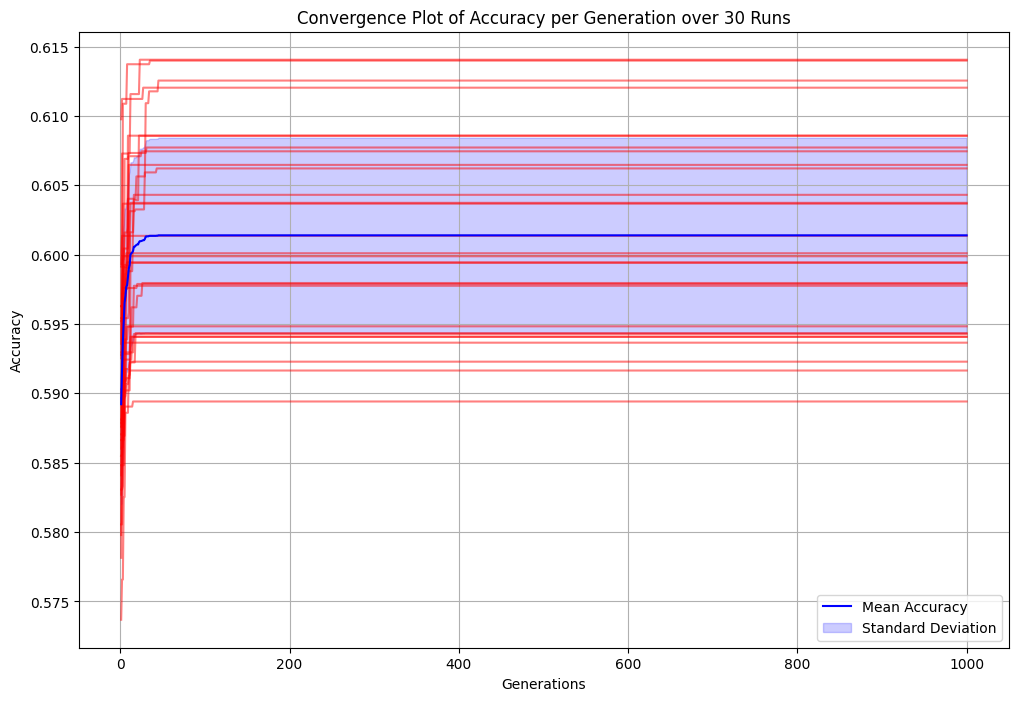

In [ ]:
import matplotlib.pyplot as plt

# Determine the maximum number of generations across all runs
max_generations = max(len(fitness) for fitness in all_best_fitness)
generations = np.arange(1, max_generations + 1)

# Initialize a matrix to hold all fitness values, handling varying lengths
fitness_matrix = np.full((30, max_generations), np.nan)

for i, best_fitness_per_gen in enumerate(all_best_fitness):
    fitness_length = len(best_fitness_per_gen)
    fitness_matrix[i, :fitness_length] = best_fitness_per_gen

# Plot all runs in light gray
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.plot(
        generations,
        fitness_matrix[i],
        linestyle='-',
        color='red',
        alpha=0.5
    )

# Compute the mean and standard deviation across runs at each generation
mean_fitness = np.nanmean(fitness_matrix, axis=0)
std_fitness = np.nanstd(fitness_matrix, axis=0)

# Plot the mean best fitness
plt.plot(
    generations,
    mean_fitness,
    linestyle='-',
    color='blue',
    label='Mean Accuracy'
)

# Fill the area between (mean - std) and (mean + std)
plt.fill_between(
    generations,
    mean_fitness - std_fitness,
    mean_fitness + std_fitness,
    color='blue',
    alpha=0.2,
    label='Standard Deviation'
)

plt.title('Convergence Plot of Accuracy per Generation over 30 Runs')
plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [43]:
from tqdm import tqdm

best_models = []
all_best_fitness = []
F_arr = []
# Agregar tqdm para mostrar progreso
for i in tqdm(range(30), desc="Running Experiments"):

    best_model, best_fitness_per_gen, Fs = es(
        eval_arch,
        gens=1000,
        F=0.5,
        mu=5000,
        auto_adapt=True
    )
    F_arr.append(Fs)
    best_models.append(best_model)
    all_best_fitness.append(best_fitness_per_gen)


Se truncaron las últimas líneas 5000 del resultado de transmisión.
Running Experiments: 100%|██████████| 30/30 [7:57:49<00:00, 955.64s/it]


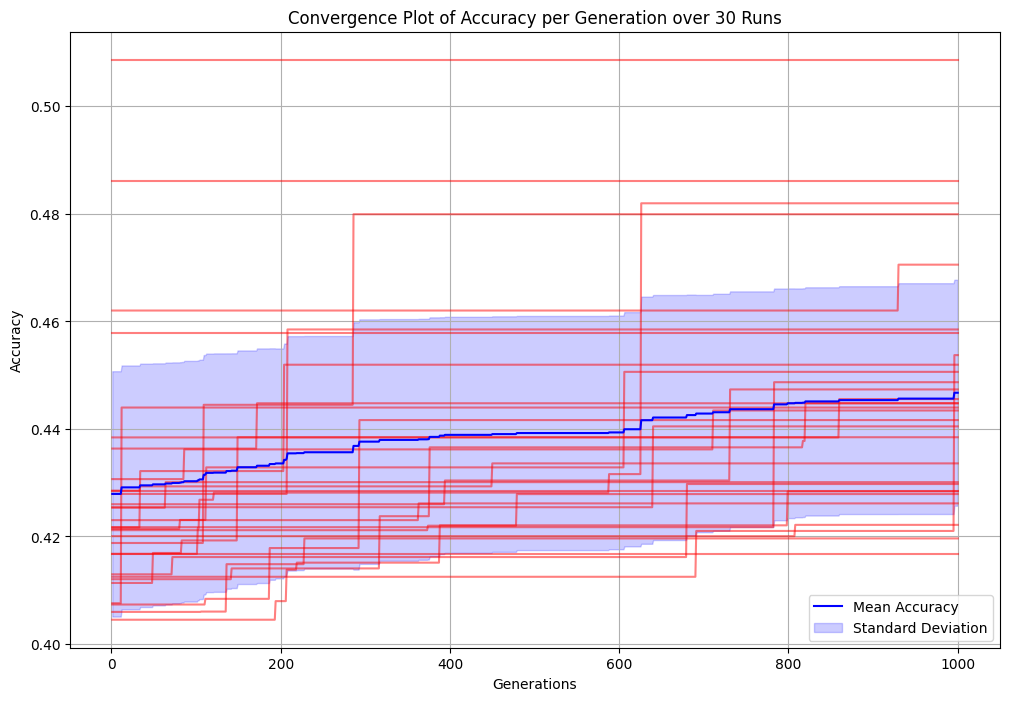

In [44]:
import matplotlib.pyplot as plt

# Determine the maximum number of generations across all runs
max_generations = max(len(fitness) for fitness in all_best_fitness)
generations = np.arange(1, max_generations + 1)

# Initialize a matrix to hold all fitness values, handling varying lengths
fitness_matrix = np.full((30, max_generations), np.nan)

for i, best_fitness_per_gen in enumerate(all_best_fitness):
    fitness_length = len(best_fitness_per_gen)
    fitness_matrix[i, :fitness_length] = best_fitness_per_gen

# Plot all runs in light gray
plt.figure(figsize=(12, 8))
for i in range(30):
    plt.plot(
        generations,
        fitness_matrix[i],
        linestyle='-',
        color='red',
        alpha=0.5
    )

# Compute the mean and standard deviation across runs at each generation
mean_fitness = np.nanmean(fitness_matrix, axis=0)
std_fitness = np.nanstd(fitness_matrix, axis=0)

# Plot the mean best fitness
plt.plot(
    generations,
    mean_fitness,
    linestyle='-',
    color='blue',
    label='Mean Accuracy'
)

# Fill the area between (mean - std) and (mean + std)
plt.fill_between(
    generations,
    mean_fitness - std_fitness,
    mean_fitness + std_fitness,
    color='blue',
    alpha=0.2,
    label='Standard Deviation'
)

plt.title('Convergence Plot of Accuracy per Generation over 30 Runs')
plt.xlabel('Generations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

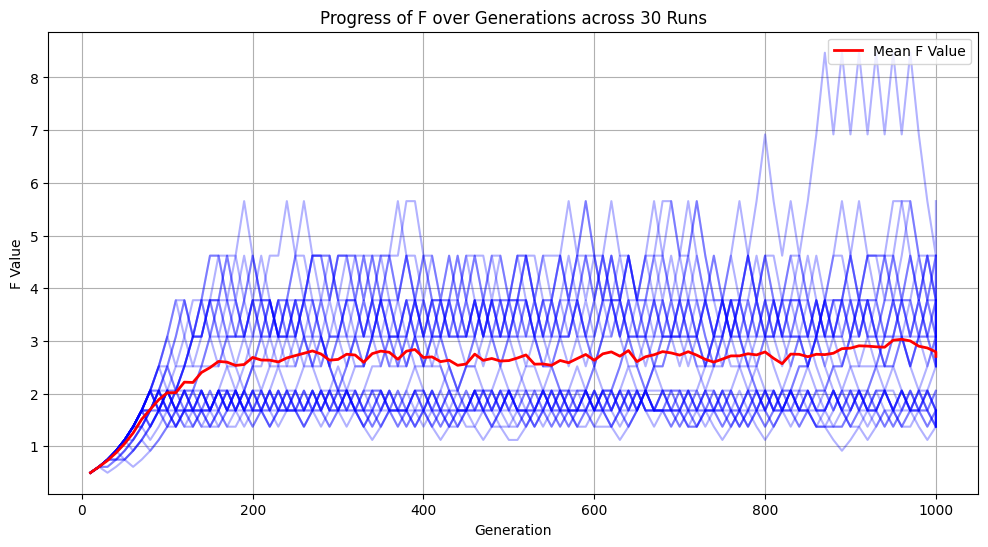

In [45]:
# Parameters
n = 10       # Adaptation interval (every n generations)
gens = 1000  # Total number of generations
num_runs = 30  # Number of runs

# Plotting
plt.figure(figsize=(12, 6))

for Fs in F_arr:
    # Generations where F was recorded
    generations = [n * i for i in range(1, len(Fs))]
    generations.append(generations[-1] + 1)
    # Adjust the last generation if it doesn't align with n
    if generations[-1] != gens:
        generations[-1] = gens
    plt.plot(generations, Fs, alpha=0.3, color='blue')

# Calculate and plot the mean F value at each adaptation point
max_length = max(len(Fs) for Fs in F_arr)

# Pad shorter Fs lists if necessary
Fs_padded = []
for Fs in F_arr:
    padding_length = max_length - len(Fs)
    Fs_padded.append(Fs + [Fs[-1]] * padding_length)

mean_Fs = [sum(Fs[i] for Fs in Fs_padded) / num_runs for i in range(max_length)]
mean_generations = [n * i for i in range(1, max_length)]
mean_generations.append(mean_generations[-1] + 1)
# Adjust the last generation if necessary
if mean_generations[-1] != gens:
    mean_generations[-1] = gens

plt.plot(mean_generations, mean_Fs, color='red', linewidth=2, label='Mean F Value')

# Label the axes and add a title
plt.xlabel('Generation')
plt.ylabel('F Value')
plt.title('Progress of F over Generations across 30 Runs')
plt.grid(True)
plt.legend(loc='upper right')

# Display the plot
plt.show()

In [46]:
best_model = max(best_models, key=lambda x: x['fitness'])
best_model['fitness']

0.5086797843097632

In [55]:
print(best_model['individual'])

[6, 9, 0, 1, 3, 3, 0, 0, 2, 1, 0, 0, 7, 0, 0, 0, 5, 0, 0, 0, 3, 2, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 7, 0, 0, 0, 8, 3, 2, 0, 1, 0, 0, 0, 7, 0, 0, 0]


In [47]:
model_dict = decode_model_architecture(best_model['individual'])
model_dict

{'layers': [{'type': 'Conv2D',
   'filters': 32,
   'strides': 1,
   'activation': 'relu'},
  {'type': 'DepthwiseConv2D',
   'filters': 9,
   'strides': 1,
   'activation': 'leaky_relu'},
  {'type': 'Dropout', 'rate': 0.5},
  {'type': 'MaxPooling', 'strides': 2},
  {'type': 'DontCare'},
  {'type': 'Flatten'},
  {'type': 'Dropout', 'rate': 0.4},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'DontCare'},
  {'type': 'BatchNorm'},
  {'type': 'DontCare'},
  {'type': 'Flatten'},
  {'type': 'Dense', 'units': 1, 'activation': 'sigmoid'}]}

In [48]:
cnn = build_tf_model_from_dict(model_dict)
cnn


Construyendo el modelo en TensorFlow desde el JSON expandido...


<Sequential name=sequential, built=True>

In [52]:
cnn.save('/drive/MyDrive/NAS/EC_Project/best_model_mu100_gens1000_F0p5_5000mu_autoadapt.h5')

In [53]:
cnn.save('/drive/MyDrive/NAS/EC_Project/best_model_mu100_gens1000_F0p5_5000mu_autoadapt.keras')